#### Print your name

In [1]:
## Your code here 
print("Exercise by: Janne Bragge")

Exercise by: Janne Bragge


# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [3]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [4]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [5]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
# note. At this point the network is not trained!

print(top_class[:10,:])
print("Correct labels:", labels[:10])

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7]])
Correct labels: tensor([1, 7, 9, 3, 7, 7, 8, 6, 8, 8])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [6]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [7]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 15.625%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```


***
### Exercise: 
Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

**Hint.** Use this frame for your solution
```python

train_losses1 = []
test_losses1 = []
test_accuracy1 = []

model1 = Classifier()
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.003)

epochs = 30
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model1(images)
        loss = criterion1(log_ps, labels)
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
```

In [8]:
## Task 1:
## Your code here 

train_losses1 = []
test_losses1 = []
test_accuracy1 = []

model1 = Classifier()
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.003)

epochs = 30
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer1.zero_grad()
        
        log_ps = model1(images)
        loss = criterion1(log_ps, labels)
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        
    else:
        # Validation phase
        model1.eval()
        accuracy = 0
        test_loss = 0

        # Move model to GPU if available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1.to(device)

        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)

                log_ps = model1(images)
                test_loss += criterion1(log_ps, labels).item()

                # Calculate accuracy
                ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Store losses and accuracy
        train_losses1.append(running_loss / len(trainloader))
        test_losses1.append(test_loss / len(testloader))
        test_accuracy1.append(accuracy / len(testloader))

        # Print output in the requested format
        print(f"Epoch: {e+1}/{epochs}..  "
                f"Training Loss: {train_losses1[-1]:.3f}..  "
                f"Test Loss: {test_losses1[-1]:.3f}..  "
                f"Test Accuracy: {test_accuracy1[-1]:.3f}")


Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.472..  Test Accuracy: 0.826
Epoch: 2/30..  Training Loss: 0.392..  Test Loss: 0.428..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.360..  Test Loss: 0.396..  Test Accuracy: 0.861
Epoch: 4/30..  Training Loss: 0.338..  Test Loss: 0.357..  Test Accuracy: 0.870
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.371..  Test Accuracy: 0.870
Epoch: 6/30..  Training Loss: 0.305..  Test Loss: 0.359..  Test Accuracy: 0.872
Epoch: 7/30..  Training Loss: 0.297..  Test Loss: 0.390..  Test Accuracy: 0.866
Epoch: 8/30..  Training Loss: 0.285..  Test Loss: 0.378..  Test Accuracy: 0.872
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.374..  Test Accuracy: 0.869
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.358..  Test Accuracy: 0.879
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.371..  Test Accuracy: 0.878
Epoch: 12/30..  Training Loss: 0.253..  Test Loss: 0.396..  Test Accuracy: 0.875
Epoch: 13/30..  Training Loss: 0.248.

***
## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='../data/assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

***
### Exercise:

**Part A**: Define network with dropout.

In [9]:
## Task 2:
## Your code here

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

 

***
**Part B**: Train the network with Fashion-MNIST again.
- monitor the training progress with the validation loss and accuracy

In [10]:
# Initialize model, loss function, and optimizer
model2 = Classifier()
criterion2 = nn.NLLLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.003)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Track losses and accuracy
train_losses2 = []
test_losses2 = []
test_accuracy2 = []

# Training loop
epochs = 30
for e in range(epochs):
    running_loss = 0

    # Training phase
    model2.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        
        optimizer2.zero_grad()
        
        log_ps = model2(images)
        loss = criterion2(log_ps, labels)
        loss.backward()
        optimizer2.step()
        
        running_loss += loss.item()

    else:
        # Validation phase
        model2.eval()  # Set model to evaluation mode
        accuracy = 0
        test_loss = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)

                log_ps = model2(images)
                test_loss += criterion2(log_ps, labels).item()

                # Calculate accuracy
                ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Store losses and accuracy
        train_losses2.append(running_loss / len(trainloader))
        test_losses2.append(test_loss / len(testloader))
        test_accuracy2.append(accuracy / len(testloader))

        # Print results in the required format
        print(f"Epoch: {e+1}/{epochs}..  "
              f"Training Loss: {train_losses2[-1]:.3f}..  "
              f"Test Loss: {test_losses2[-1]:.3f}..  "
              f"Test Accuracy: {test_accuracy2[-1]:.3f}")



Epoch: 1/30..  Training Loss: 0.606..  Test Loss: 0.464..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.484..  Test Loss: 0.422..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.448..  Test Loss: 0.419..  Test Accuracy: 0.847
Epoch: 4/30..  Training Loss: 0.428..  Test Loss: 0.417..  Test Accuracy: 0.847
Epoch: 5/30..  Training Loss: 0.420..  Test Loss: 0.396..  Test Accuracy: 0.861
Epoch: 6/30..  Training Loss: 0.412..  Test Loss: 0.405..  Test Accuracy: 0.856
Epoch: 7/30..  Training Loss: 0.399..  Test Loss: 0.401..  Test Accuracy: 0.858
Epoch: 8/30..  Training Loss: 0.401..  Test Loss: 0.388..  Test Accuracy: 0.866
Epoch: 9/30..  Training Loss: 0.390..  Test Loss: 0.434..  Test Accuracy: 0.844
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.380..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.385..  Test Loss: 0.397..  Test Accuracy: 0.860
Epoch: 12/30..  Training Loss: 0.382..  Test Loss: 0.399..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.377.

# Drop rate 40 %

In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [12]:
# Initialize model, loss function, and optimizer
model3 = Classifier()
criterion3 = nn.NLLLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.003)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

# Track losses and accuracy
train_losses3 = []
test_losses3 = []
test_accuracy3 = []

# Training loop
epochs = 30
for e in range(epochs):
    running_loss = 0

    # Training phase
    model3.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        
        optimizer3.zero_grad()
        
        log_ps = model3(images)
        loss = criterion3(log_ps, labels)
        loss.backward()
        optimizer3.step()
        
        running_loss += loss.item()

    else:
        # Validation phase
        model3.eval()  # Set model to evaluation mode
        accuracy = 0
        test_loss = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)

                log_ps = model3(images)
                test_loss += criterion3(log_ps, labels).item()

                # Calculate accuracy
                ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Store losses and accuracy
        train_losses3.append(running_loss / len(trainloader))
        test_losses3.append(test_loss / len(testloader))
        test_accuracy3.append(accuracy / len(testloader))

        # Print results in the required format
        print(f"Epoch: {e+1}/{epochs}..  "
              f"Training Loss: {train_losses3[-1]:.3f}..  "
              f"Test Loss: {test_losses3[-1]:.3f}..  "
              f"Test Accuracy: {test_accuracy3[-1]:.3f}")
        

Epoch: 1/30..  Training Loss: 0.745..  Test Loss: 0.532..  Test Accuracy: 0.818
Epoch: 2/30..  Training Loss: 0.608..  Test Loss: 0.481..  Test Accuracy: 0.829
Epoch: 3/30..  Training Loss: 0.569..  Test Loss: 0.460..  Test Accuracy: 0.835
Epoch: 4/30..  Training Loss: 0.555..  Test Loss: 0.442..  Test Accuracy: 0.841
Epoch: 5/30..  Training Loss: 0.552..  Test Loss: 0.448..  Test Accuracy: 0.846
Epoch: 6/30..  Training Loss: 0.540..  Test Loss: 0.457..  Test Accuracy: 0.837
Epoch: 7/30..  Training Loss: 0.529..  Test Loss: 0.436..  Test Accuracy: 0.847
Epoch: 8/30..  Training Loss: 0.532..  Test Loss: 0.440..  Test Accuracy: 0.842
Epoch: 9/30..  Training Loss: 0.526..  Test Loss: 0.447..  Test Accuracy: 0.844
Epoch: 10/30..  Training Loss: 0.520..  Test Loss: 0.441..  Test Accuracy: 0.848
Epoch: 11/30..  Training Loss: 0.519..  Test Loss: 0.420..  Test Accuracy: 0.848
Epoch: 12/30..  Training Loss: 0.509..  Test Loss: 0.417..  Test Accuracy: 0.856
Epoch: 13/30..  Training Loss: 0.512.

# drop rate 60%

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.6)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [14]:
# Initialize model, loss function, and optimizer
model4 = Classifier()
criterion4 = nn.NLLLoss()
optimizer4 = optim.Adam(model4.parameters(), lr=0.003)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.to(device)

# Track losses and accuracy
train_losses4 = []
test_losses4 = []
test_accuracy4 = []

# Training loop
epochs = 30
for e in range(epochs):
    running_loss = 0

    # Training phase
    model4.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        
        optimizer4.zero_grad()
        
        log_ps = model4(images)
        loss = criterion4(log_ps, labels)
        loss.backward()
        optimizer4.step()
        
        running_loss += loss.item()

    else:
        # Validation phase
        model4.eval()  # Set model to evaluation mode
        accuracy = 0
        test_loss = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)

                log_ps = model4(images)
                test_loss += criterion4(log_ps, labels).item()

                # Calculate accuracy
                ps = torch.exp(log_ps)  # Convert log probabilities to probabilities
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        # Store losses and accuracy
        train_losses4.append(running_loss / len(trainloader))
        test_losses4.append(test_loss / len(testloader))
        test_accuracy4.append(accuracy / len(testloader))

        # Print results in the required format
        print(f"Epoch: {e+1}/{epochs}..  "
              f"Training Loss: {train_losses4[-1]:.3f}..  "
              f"Test Loss: {test_losses4[-1]:.3f}..  "
              f"Test Accuracy: {test_accuracy4[-1]:.3f}")


Epoch: 1/30..  Training Loss: 1.018..  Test Loss: 0.658..  Test Accuracy: 0.758
Epoch: 2/30..  Training Loss: 0.853..  Test Loss: 0.622..  Test Accuracy: 0.777
Epoch: 3/30..  Training Loss: 0.816..  Test Loss: 0.590..  Test Accuracy: 0.786
Epoch: 4/30..  Training Loss: 0.798..  Test Loss: 0.592..  Test Accuracy: 0.789
Epoch: 5/30..  Training Loss: 0.801..  Test Loss: 0.547..  Test Accuracy: 0.797
Epoch: 6/30..  Training Loss: 0.771..  Test Loss: 0.550..  Test Accuracy: 0.795
Epoch: 7/30..  Training Loss: 0.784..  Test Loss: 0.547..  Test Accuracy: 0.800
Epoch: 8/30..  Training Loss: 0.774..  Test Loss: 0.578..  Test Accuracy: 0.786
Epoch: 9/30..  Training Loss: 0.772..  Test Loss: 0.567..  Test Accuracy: 0.797
Epoch: 10/30..  Training Loss: 0.780..  Test Loss: 0.553..  Test Accuracy: 0.797
Epoch: 11/30..  Training Loss: 0.768..  Test Loss: 0.552..  Test Accuracy: 0.811
Epoch: 12/30..  Training Loss: 0.769..  Test Loss: 0.570..  Test Accuracy: 0.805
Epoch: 13/30..  Training Loss: 0.770.

***
**Part C**: Plot training loss and validation loss to see if you can get a lower validation loss or higher accuracy.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

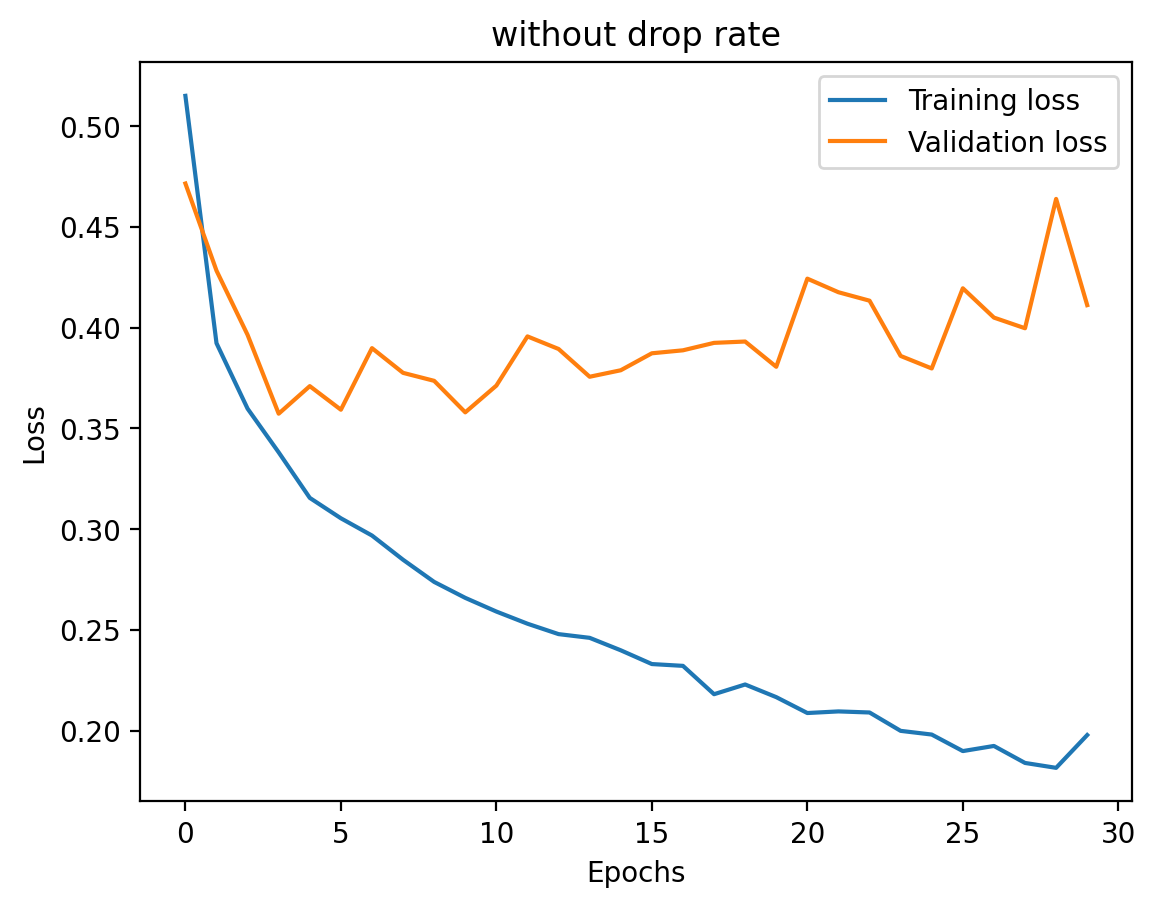

In [16]:
# Plot Training & Validation Loss
plt.plot(train_losses1, label="Training loss")
plt.plot(test_losses1, label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("without drop rate")
plt.show()

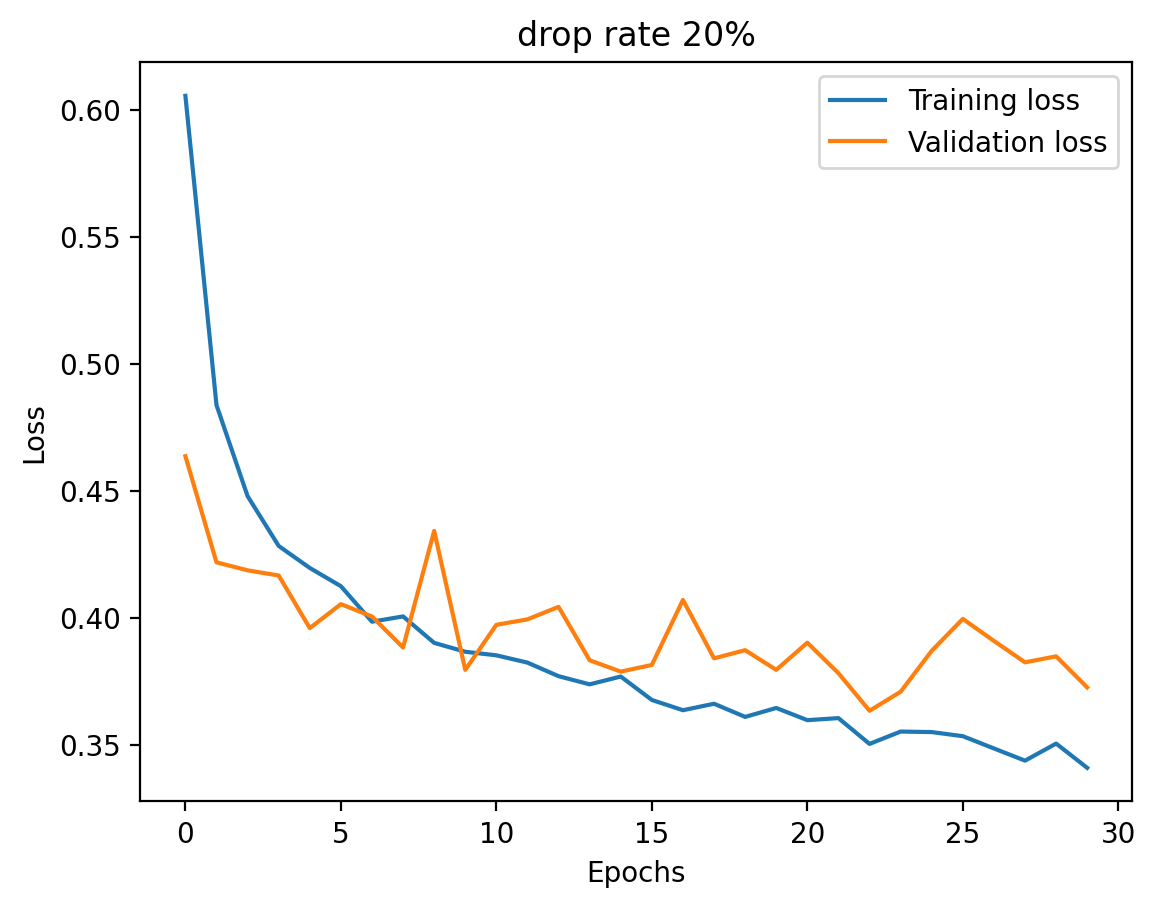

In [17]:
## Task 4:
## Your code here 


# Plot Training & Validation Loss
plt.plot(train_losses2, label="Training loss")
plt.plot(test_losses2, label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("drop rate 20%")
plt.show()


***
### More about overfitting 

"Dropout" method helps to cope with overfitting. However it makes model debuging bit harder and you must remember to turn dropout OFF while using the network, i.e. dropout is used only in training. But don't worry Pytorch will do it for you if you remember initialize dropout 

```python
# Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
```

and set model to evaluation mode
        
```python
# set model to evaluation mode
    model.eval()
```       

these are not preferred method for overfitting.

#### Other methods to cope with overfitting

##### Early-stopping

Training stopping at the point where it reaches best performance (= minimum error/loss), is also used to cope with overfitting, but this is not recommended because this limits training data usage to some maximum amount. And because modern deep learning models are based to training with big data amounts, this is very tricky combination...

<img src='../data/assets/Early_stopping.svg' width=400px>


##### Regulation
Another very popular method for overfitting is regularization. This method is based on target to minimize weights (=co-efficients = w) in the network. This is done by adding the `|w|` or `|w|^2` to loss function.

<img src='../data/assets/Error_function_reg.svg' width=700px>



## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

Label: 5


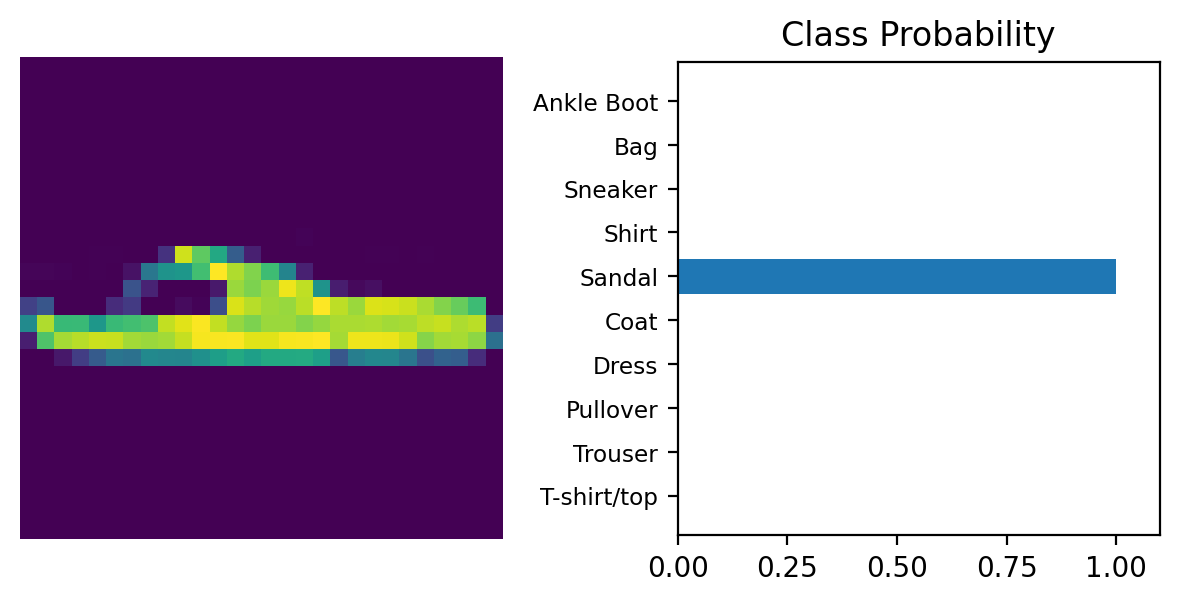

In [18]:
# Import helper module (should be in the repo)
import sys
sys.path.insert(0, '../answers')
import helper

# Test out your network!

model2.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model2.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

print('Label:', labels[0].item())

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.

## Reflection

Answer briefly following questions (in English or Finnish):
**What is overfitting?**

overfitting occurs when the model decides to reflect the data presented in the training set rather than produce a generalized solution. You’ll often hear people talking about how a particular model memorized the dataset, meaning the model learned the answers and went on to perform poorly on production data.

How to identify overfitting: 
- Training loss decreases, but validation loss increases.
- High accuracy on training set, but low accuracy on test/validation set.
- Model predictions are too specific to the training examples (memorization instead of generalization)


**How you can avoid overfitting?**
- Use More Training Data (helps the model generalize better)
- Data Augmentation (apply transformations to expand the dataset)
- Dropout Regularization (randomly drop neurons during training)
- Early Stopping (stop training when validation loss starts increasing)
. Reduce Model Complexity (fewer layers or parameters)

Pointer, I. (2019)

#### Network Performance

**Does network Training Loss decrease monotonously? What about Validation Loss?**

Training Loss: Mostly decreases monotonously, with slight fluctuations but an overall downward trend.
Validation Loss: Not monotonous—it fluctuates significantly toward the end, indicating possible overfitting.

**Is the performance better when using dropout with 20% drop rate? What about if you change drop rate?**

A 20% drop rate provides the best balance, reducing overfitting while maintaining learning ability.
Higher dropout rates (40% and 60%) degrade performance, as too much information is lost during training.
Using no dropout leads to overfitting.

Check the pictures in the next cell.

---

Reference:
Pointer, I. (2019). Programming PyTorch for deep learning: Creating and deploying deep learning applications. O'Reilly Media


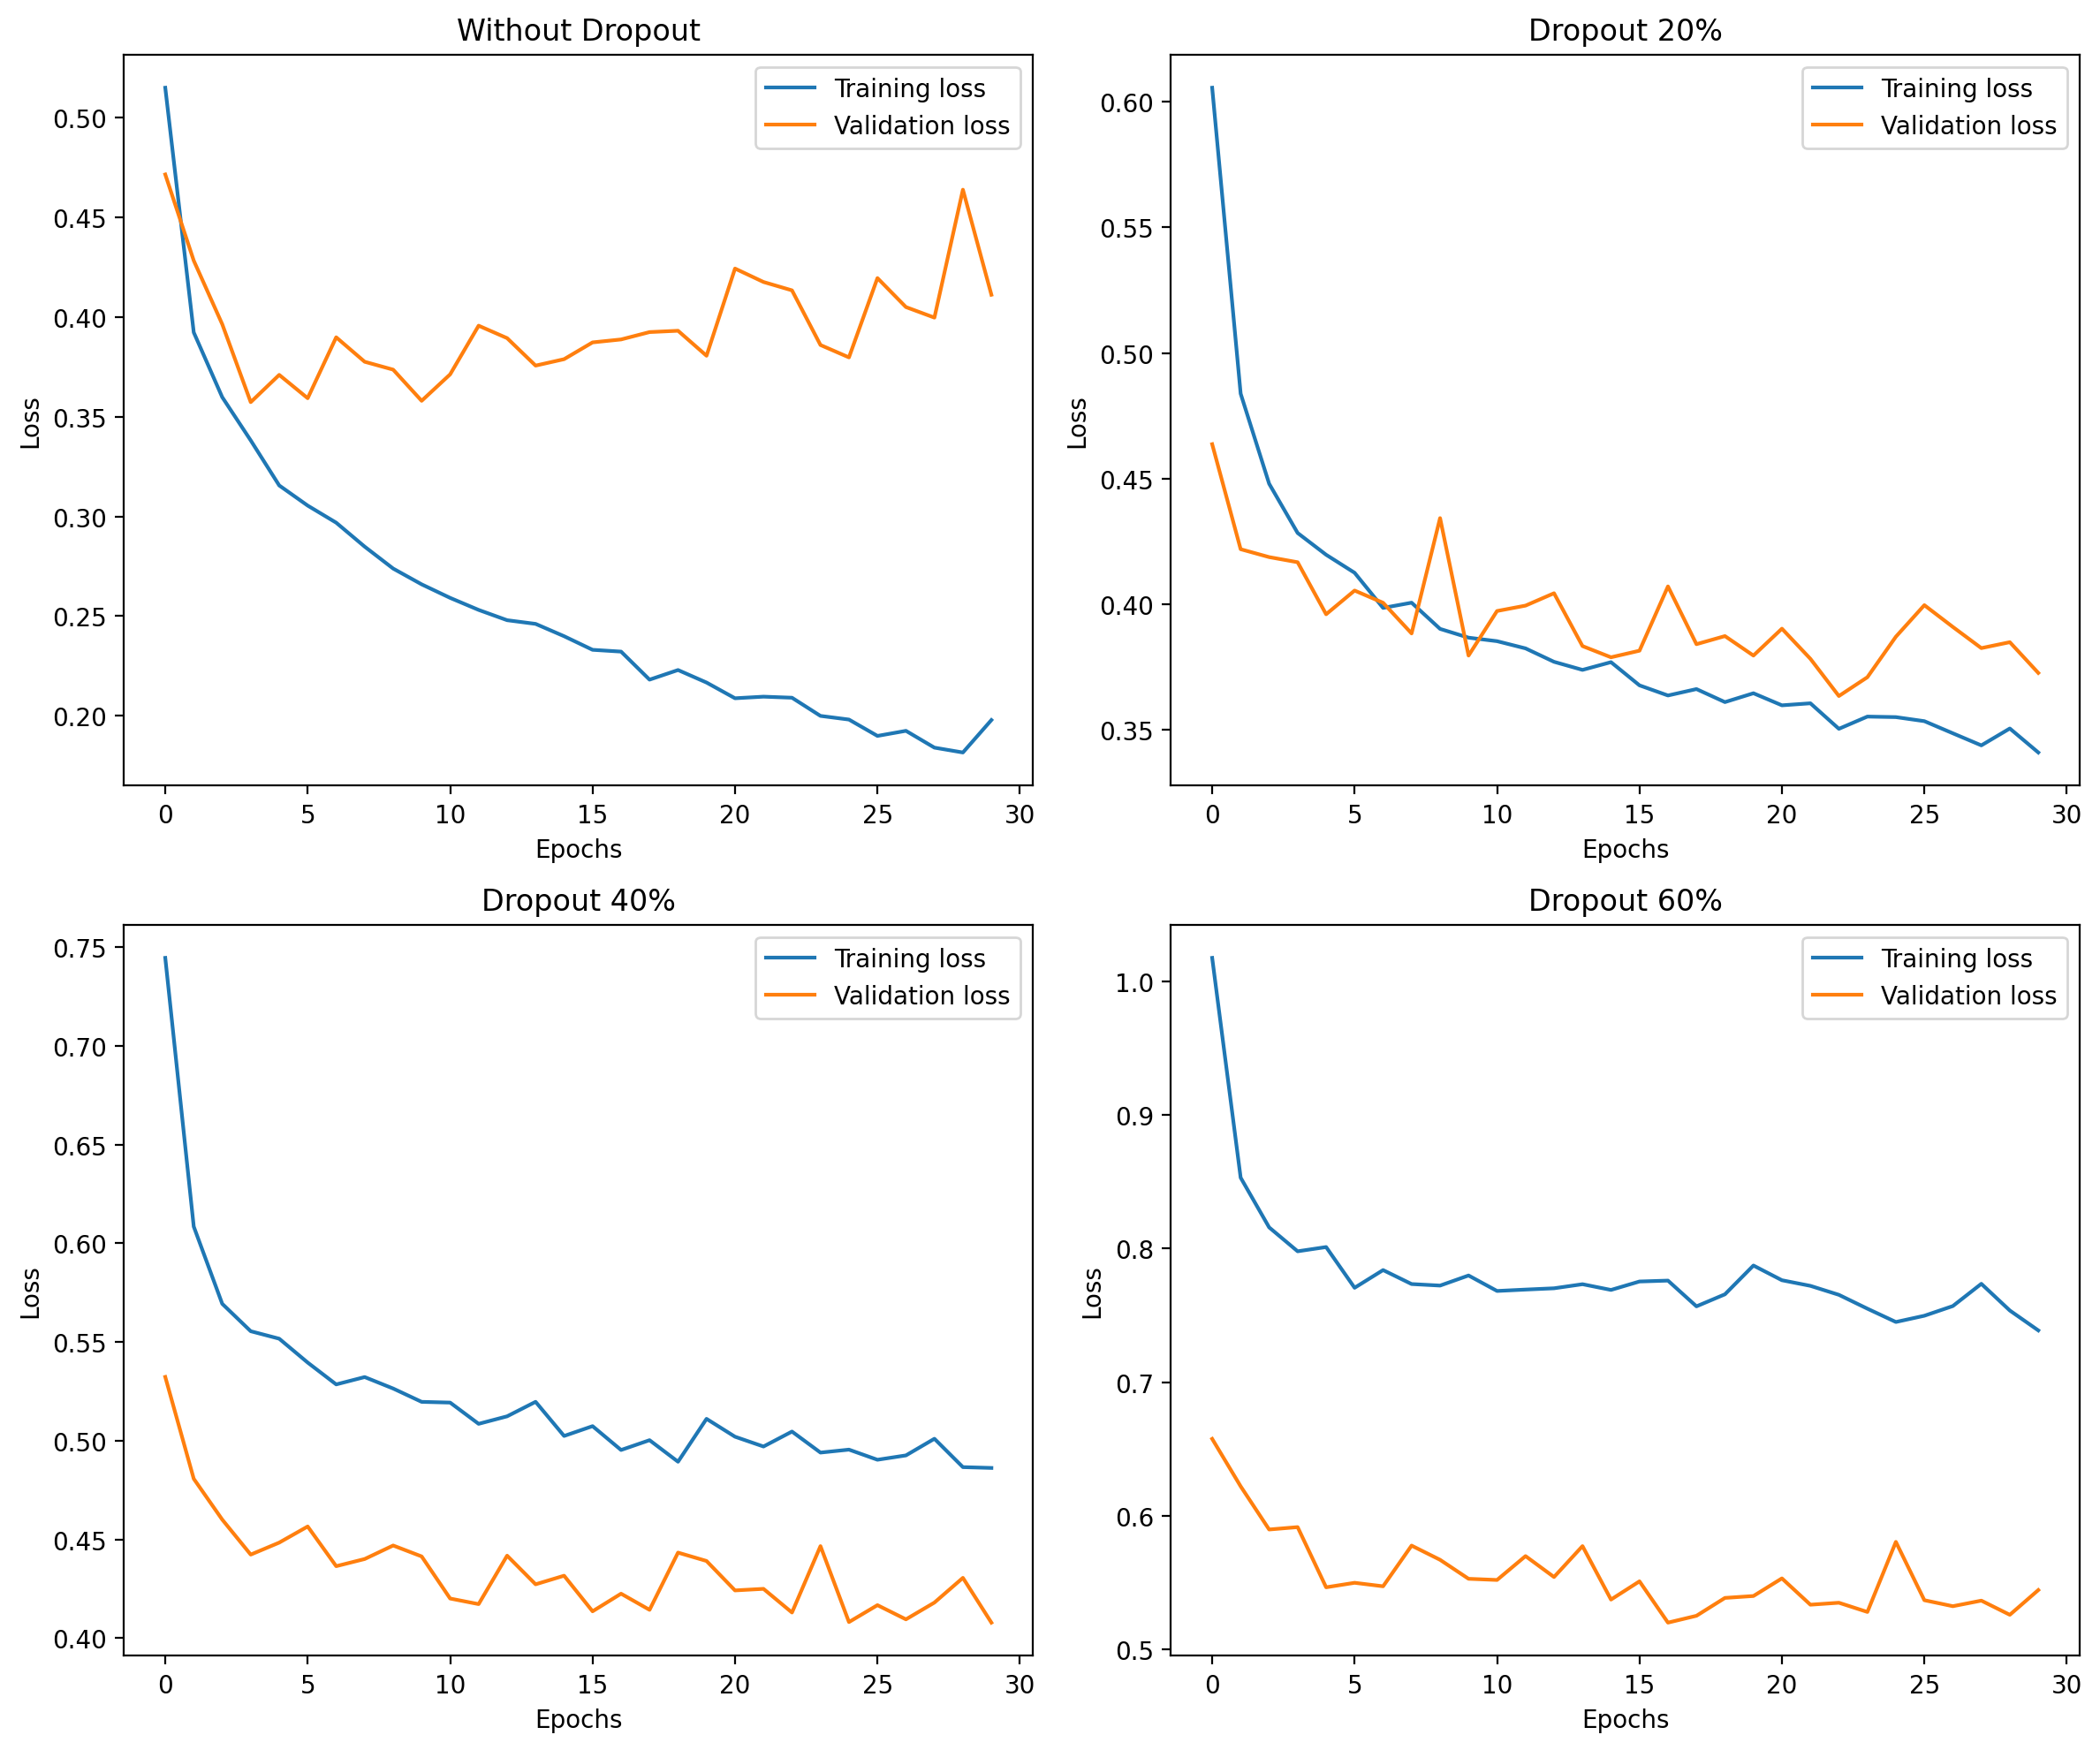

In [19]:
import matplotlib.pyplot as plt

# Define titles and data lists
titles = ["Without Dropout", "Dropout 20%", "Dropout 40%", "Dropout 60%"]
train_losses = [train_losses1, train_losses2, train_losses3, train_losses4]
test_losses = [test_losses1, test_losses2, test_losses3, test_losses4]

# Create subplots (2x2 layout)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    ax.plot(train_losses[i], label="Training loss")
    ax.plot(test_losses[i], label="Validation loss")
    ax.set_title(titles[i])
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

plt.tight_layout()
plt.show()


*Your answers here...*

### Check your answers by running following cell:

In [20]:
# Do not change this code!

import sys
sys.path.insert(0, '../answers/part5/')
from part5_check import *


print("Results:\n")

print("Without dropout:")
print(model1)
print(criterion1)
print(optimizer1)

print("\nWith dropout:")
print(model2)
print(criterion2)
print(optimizer2)

losses_check(train_losses1, test_losses1, train_losses2, test_losses2)
accuracies_check(test_accuracy1, test_accuracy2)


Results:

Without dropout:
Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)

With dropout:
Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
NLLLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fus

### Great work!